In [1]:
import nn_functions

# To do:
- epochs minimo 200
- ponerle una tol a las loss funciont
- no probar sobre TOOODAS las combinaciones de hiperparametros (beta de adam 2 valores, epochs mas o menos fijo)
- hacer visualizacion de funcion de costo
- ver el autovalor maximo vs epochs


mucha energia en los k bajo, poca energia en los k alto.

transformada de fourier en el medio de la imagen en el eje y, a lo largo del eje x. 

# Preguntas Pato:
- Al momento de hacer histogramas activaciones, tenemos que usar los mismos inputs para evaluar como van cambiando los histpgramas a medida que avanza el entrenamiento.
- el hessiano esta bien calcularlo en 1 un batch?
- como visualizamos el espectro del hessiano? tipo de analisis?
-  curva de numero de condicion vs epocjs
- cuando no estas en un punto critico, que significa tener autoval positivo y negativo? saddle point ?
- mostrar histogramas de hessiano

In [4]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn

import matplotlib.pyplot as plt

from nn_functions import init_network_params, pack_params, layer_sizes, unpack_params
from nn_functions import update_rmsprop, update_sgd, compute_hessian, update_adam
from nn_functions import get_batches, loss, batched_predict, batched_predict_with_activations

Evaluar la performance de cada optimizador estudiando el valor de la función de costo, la calidad del
ajuste, número de iteraciones necesarias para converger (si es posible). Puede incluir también histogramas de las activaciones de las redes y de los gradientes, y calcular el espectro del Hessiano a lo largo
del entrenamiento.

# 1. Evaluar performarnce SGD estudiando el valor de la funcion de costo

In [5]:
# Load data
field = jnp.load('field.npy')
field = field - field.mean()
field = field / field.std()
field = jnp.array(field, dtype=jnp.float32)
nx, ny = field.shape
xx = jnp.linspace(-1, 1, nx)
yy = jnp.linspace(-1, 1, ny)
xx, yy = jnp.meshgrid(xx, yy, indexing='ij')
xx = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
ff = field.reshape(-1, 1)

SGD con minibatch

In [6]:
# Parameters
num_epochs = 200
params = init_network_params(layer_sizes, random.key(0))
params = pack_params(params)
batch_size=512

# optimizer
#update = update_sgd
update = update_adam
step_size = 0.001

# initialize gradients
xi, yi = next(get_batches(xx, ff, bs=32))  # xi:[x,y], yi:color
grads = grad(loss)(params, xi, yi)
aux = jnp.square(grads) # necesario para optimizador, paso anterior
# Training
log_train = []
log_grads = []
log_activations = []
log_hessian = [] 
for epoch in range(num_epochs):
    # Update on each batch
    idxs = random.permutation(random.key(0), xx.shape[0])
    for xi, yi in get_batches(xx[idxs], ff[idxs], bs=batch_size):
        params, aux, grads = update(params, xi, yi, step_size, aux)
    
    train_loss= loss(params, xx, ff)
    log_train.append(train_loss.item()) # funcion de costo
    if epoch % 20 == 0:
        log_grads.append(grads) # un array de shape 4000 aprox
        # Obtener activaciones sobre todo el dataset
        outputs, activations = batched_predict_with_activations(params, xx) # para toda la imagen xx= (77184, 2)
       # outputs, activations = batched_predict_with_activations(params, xi)
        # activations es una lista de arrays, uno por capa, de shape (N, neurons_in_layer)
        log_activations.append(activations)
        log_hessian.append(compute_hessian(params, xi, yi))
        print(f"Epoch {epoch}, Loss: {train_loss}")

ValueError: too many values to unpack (expected 3)

In [19]:
eigvals.max()

Array(97.8057, dtype=float32)

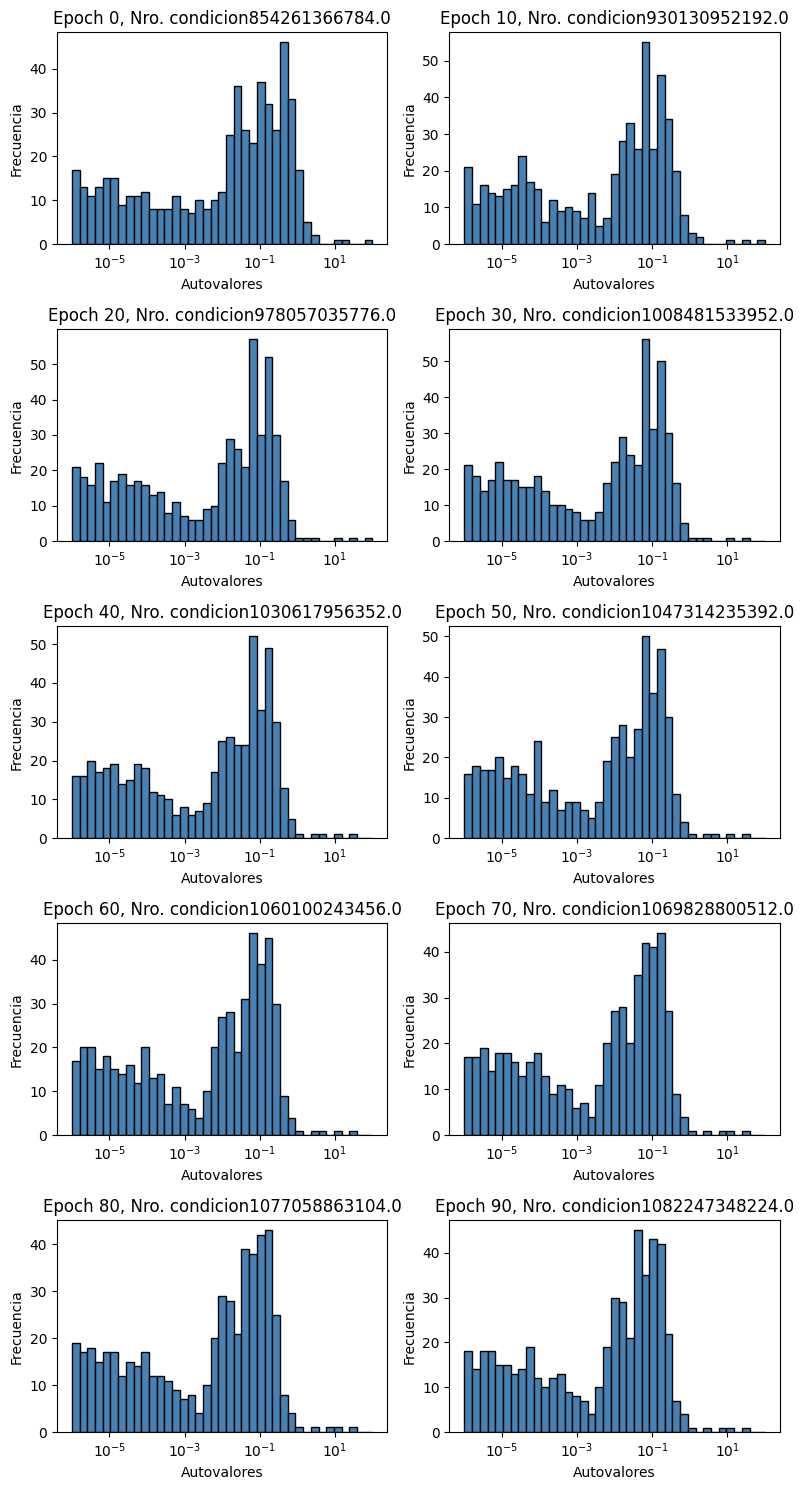

In [22]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

num_epochs = len(log_hessian)
ncols = 2  # columnas por fila
nrows = (num_epochs + ncols - 1) // ncols  # filas necesarias

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = axes.flatten()  # aplanamos para indexar fácil

for i, hessian in enumerate(log_hessian):
    eigvals, _ = jnp.linalg.eigh(hessian)
    eigvals = jnp.array(eigvals)
    abs_eig = jnp.abs(eigvals)
    

    # Para evitar división por cero en autovalores muy chicos
    lambda_max = jnp.max(abs_eig)
    lambda_min = jnp.clip(jnp.min(abs_eig), a_min=1e-10)  # evitar división por 0


    bins = jnp.logspace(jnp.log10(0.000001), jnp.log10(100), num=40)

  #  axes[i].hist(eigvals, bins=40, color="steelblue", edgecolor="black")
    axes[i].hist(eigvals, bins=bins, color="steelblue", edgecolor="black")
    axes[i].set_title(f"Epoch {i*10}, Nro. condicion{lambda_max / lambda_min}")  # o el número real si lo tenés
    axes[i].set_xlabel("Autovalores")
    axes[i].set_ylabel("Frecuencia")
    axes[i].set_xscale("log")  # ← Escala log en eje Y (frecuencia)


# Apagar subplots vacíos si hay
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [10]:
max(eigvals), min(eigvals)

(Array(114.4674, dtype=float32), Array(-1.1847738, dtype=float32))

In [21]:
xx[0]

Array([-1., -1.], dtype=float32)

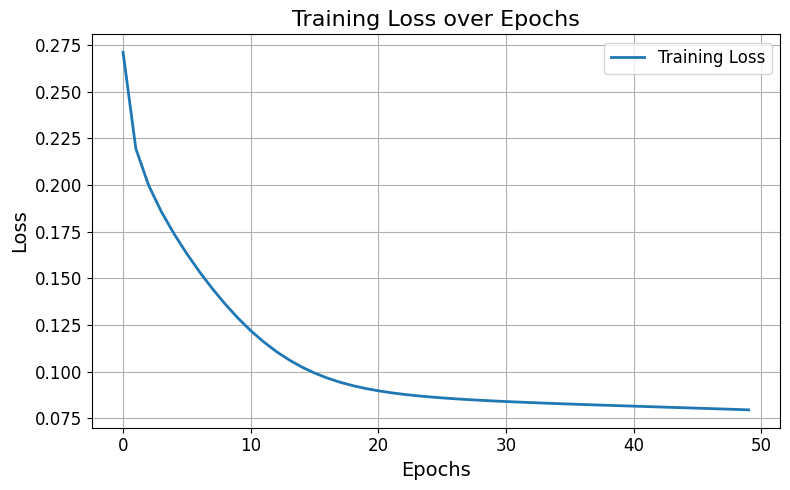

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # Tamaño del gráfico

plt.plot(log_train, label='Training Loss', linewidth=2)

plt.title('Training Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.grid(True)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


#  2. SGD: evaluar calidad del ajuste. Graficos de la imagen.

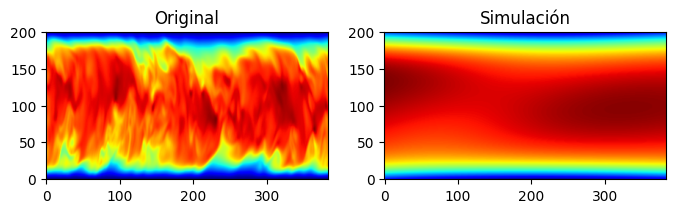

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[0].set_title(f"Original")
result= batched_predict(params, xx)
axes[1].imshow(result.reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[1].set_title(f"Simulación")

plt.show()

# To do: grafico de error por pixel, y mse contando todos los puntos.

# 3. SGD: histograma de gradientes
- histograma de componentes del gradiente por capa. entendemos que para distintas epochs. (cada tantas epochs calcular el gradiente sobre algunos puntps). 

In [ ]:
len(unpack_params(params))
len(unpack_params(params)[0][0][1])
unpack_params(params)[0][0].shape # pesos capa 0 y 1
unpack_params(params)[0][1].shape # bias capa 1

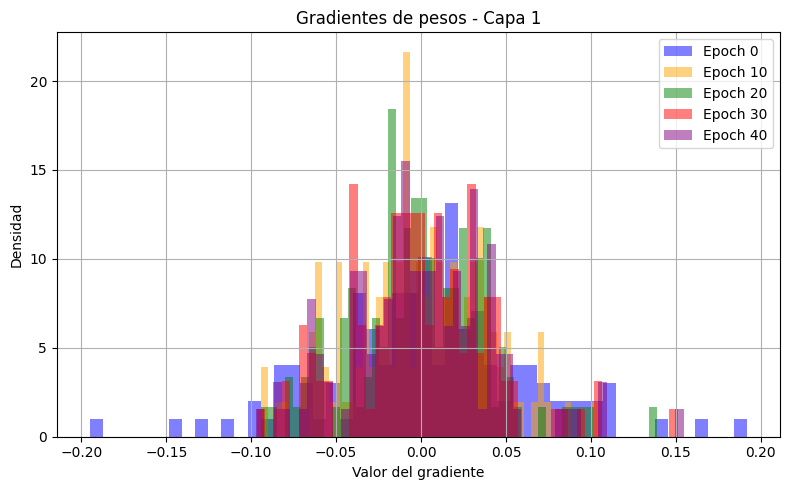

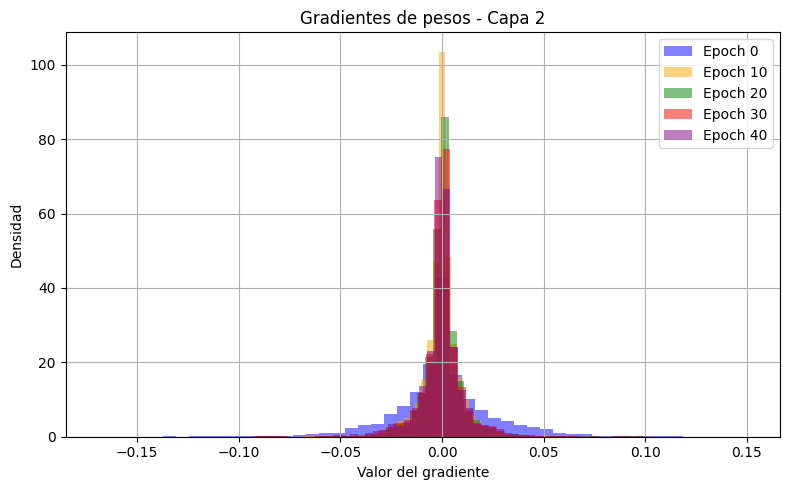

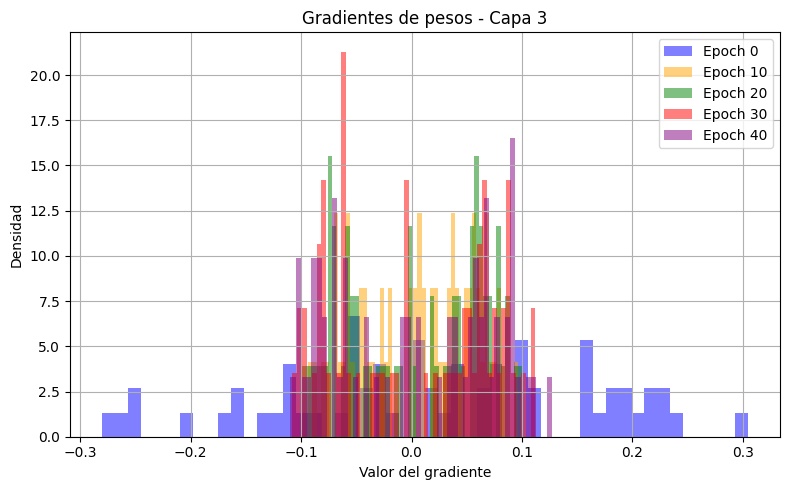

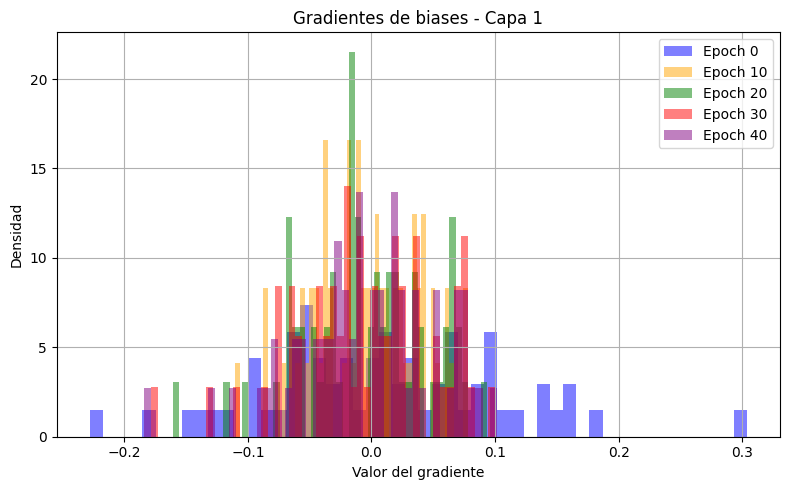

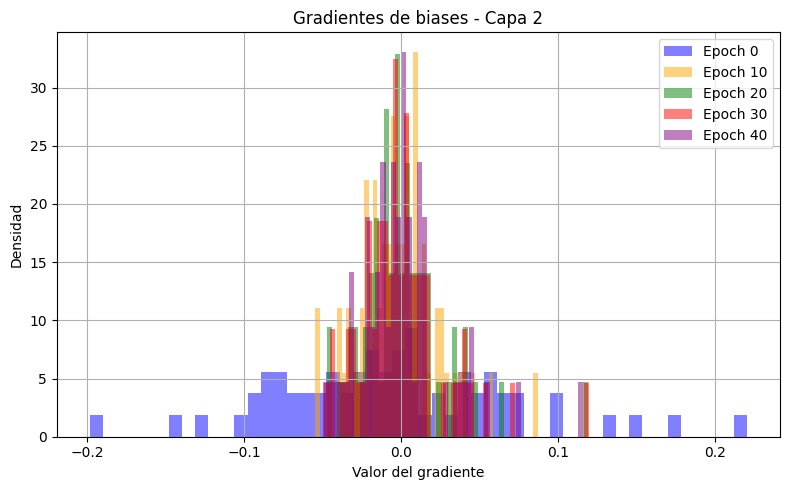

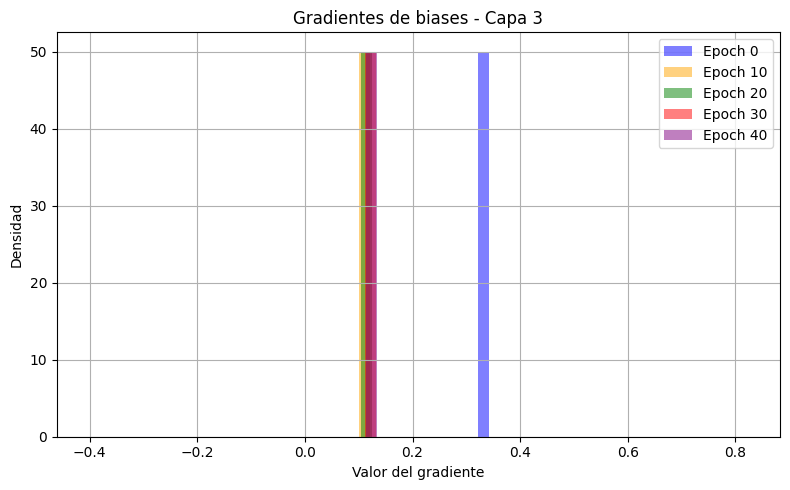

In [8]:
import matplotlib.pyplot as plt

# Inicializamos estructuras para acumular gradientes
num_layers = len(layer_sizes) - 1
grad_weights_by_layer = [[] for _ in range(num_layers)]
grad_biases_by_layer = [[] for _ in range(num_layers)]

# Recolectamos gradientes por capa y tipo
for grads in log_grads:
    layer_grads = unpack_params(grads)  # Lista de (w, b) por capa
    for i, (w, b) in enumerate(layer_grads):
        grad_weights_by_layer[i].append(w.flatten())
        grad_biases_by_layer[i].append(b.flatten())

# Colores por epoch
epochs = [i * 10 for i in range(len(log_grads))]
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Asegurate de tener >= len(log_grads)

# Función auxiliar para graficar
def plot_histograms(data_by_layer, param_type):
    for i, grad_list in enumerate(data_by_layer):
        plt.figure(figsize=(8, 5))
        for j, grad_values in enumerate(grad_list):
            plt.hist(grad_values, bins=50, alpha=0.5, density=True,
                     label=f"Epoch {epochs[j]}", color=colors[j])
        plt.title(f"Gradientes de {param_type} - Capa {i+1}")
        plt.xlabel("Valor del gradiente")
        plt.ylabel("Densidad")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Graficar pesos y luego biases
plot_histograms(grad_weights_by_layer, "pesos")
plot_histograms(grad_biases_by_layer, "biases")


# TO DO: solo graficar 3 epochs, graficar kde, eliminar los que son 1 solo valor 

# 4. SGD: histograma de activaciones 

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_activations_histogram(log_activations, layer_index, epoch_interval=10):
    plt.figure(figsize=(10, 6))
    
    num_epochs = len(log_activations)
    colors = plt.cm.viridis(np.linspace(0, 1, num_epochs))

    for i, activs in enumerate(log_activations):
        epoch = i * epoch_interval  # ya que guardás cada 10 epochs
        data = np.ravel(np.array(activs[layer_index]))  # activaciones de la capa, a 1D
        plt.hist(data, bins=50, alpha=0.5, label=f'Epoch {epoch}', color=colors[i], density=True)
        print(len(data))
    plt.title(f"Activaciones - Capa {layer_index}")
    plt.xlabel("Valor de activación")
    plt.ylabel("Densidad")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [18]:
activs = log_activations[0]
len(np.ravel(np.array(activs[0])) )

4939776

In [19]:
activs[0].shape

(77184, 64)

In [11]:
len(log_activations)

5

In [12]:
len(log_activations[0])

2

In [13]:
len(log_activations[0][0])

77184

4939776
4939776
4939776
4939776
4939776


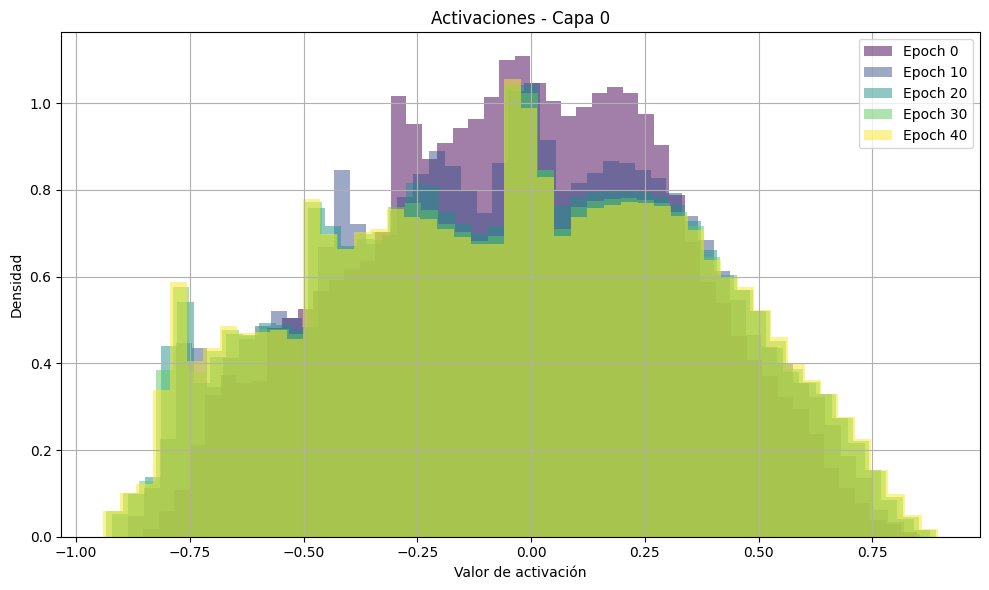

In [10]:
plot_activations_histogram(log_activations, layer_index=0)


4939776
4939776
4939776
4939776
4939776


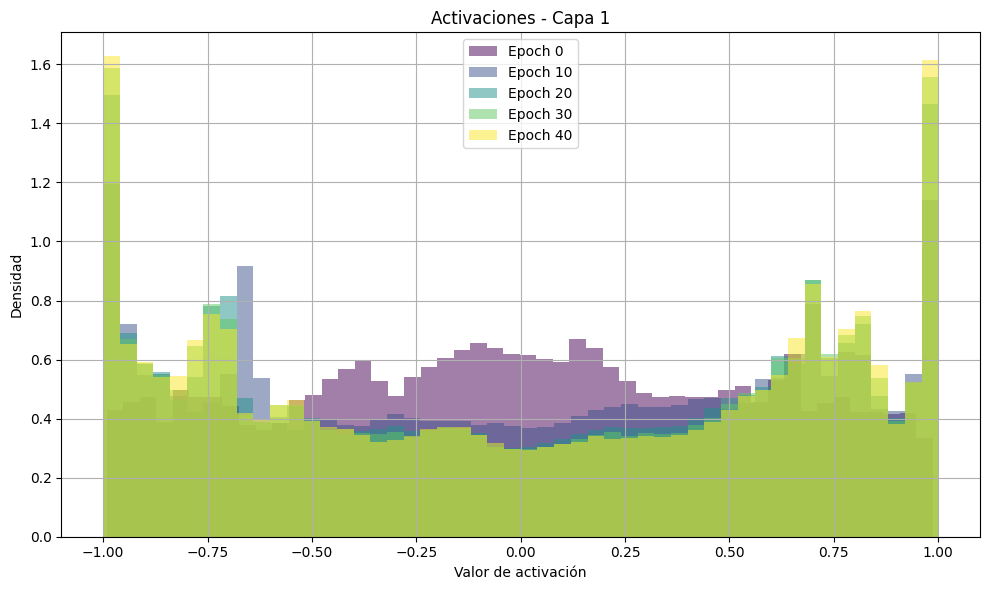

In [11]:
plot_activations_histogram(log_activations, layer_index=1)


In [16]:
len(log_activs[0][0][0])

64

In [18]:
len(log_activs[0][0][1])

64

In [ ]:
len(log_activs) # epochs

5

In [ ]:
len(log_activs[0]) # epoch 0 para todas las capas

2

In [29]:
len(log_activs[0][0]) # epoch 0 capa 1

77184

In [34]:
log_activs[0][0][0]

Array([-0.5549648 , -0.4467812 ,  0.29347697,  0.42226386,  0.15560138,
       -0.16412589,  0.10988478, -0.7264172 , -0.63700277, -0.3244409 ,
       -0.28438875,  0.41346407, -0.00984193, -0.20389324,  0.06434371,
       -0.58681077, -0.34098384, -0.2899364 ,  0.09474582, -0.04306816,
        0.6782118 , -0.7455081 ,  0.30417687, -0.3701907 ,  0.6426451 ,
       -0.71849626,  0.3963848 , -0.44047716,  0.47448853,  0.45302543,
        0.31701148,  0.32606825, -0.10132311,  0.08504581, -0.73452985,
        0.6049016 , -0.3587091 , -0.10603718,  0.3248802 , -0.6032819 ,
        0.6389412 , -0.634597  , -0.50846124, -0.32415512, -0.11687055,
        0.5259396 ,  0.7403311 ,  0.5161882 , -0.28705004,  0.715659  ,
        0.27300376, -0.2775675 , -0.2558899 , -0.07297215, -0.8467878 ,
       -0.6077864 ,  0.2382866 ,  0.54474694,  0.29312703, -0.48499247,
        0.43829682,  0.33620888,  0.01516212,  0.0188318 ], dtype=float32)

In [35]:
len(log_activs[0][0])

77184

In [30]:
64*32

2048

In [28]:
len(log_activs[0][0][0]) # epoch 0 para todas las capas

64

- histograma de gradientes: componentes o norma? por capa? entendemos que para distintas epochs. (cada tantas epochs calcular el gradiente sobre algunos puntps, lo mismo con el hessiano). ADAM converge mas rapido en histpgrama de gradiente y capas
- histograma de activaciones: idem
- numero de iteracion para converger: con norma del graddiente? en funcion de un mini batch?
- podemos aumentar nro de epochs?
- calidad del ajuste: ver el espectro de fourier, errores en la derivada cada tantos epochs
- hessiano primero guardarlo y despues calcular el espectro


In [15]:
len(grad_k)

4417

In [ ]:
layer_sizes = [2, 64, 64, 1]

hacer histograma por capas

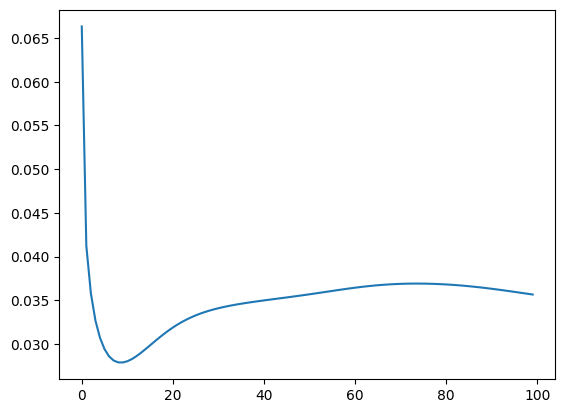

In [22]:
plt.plot(log_n_grads)

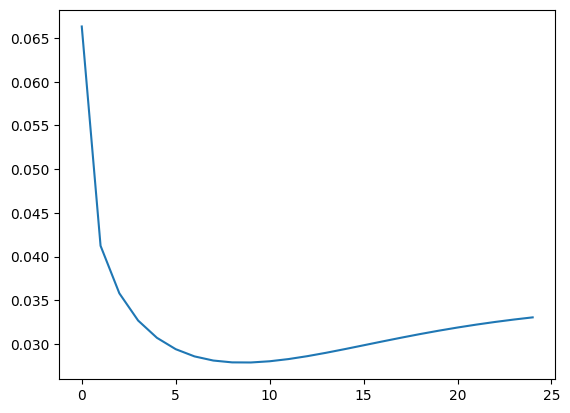

In [13]:
plt.plot(log_n_grads)

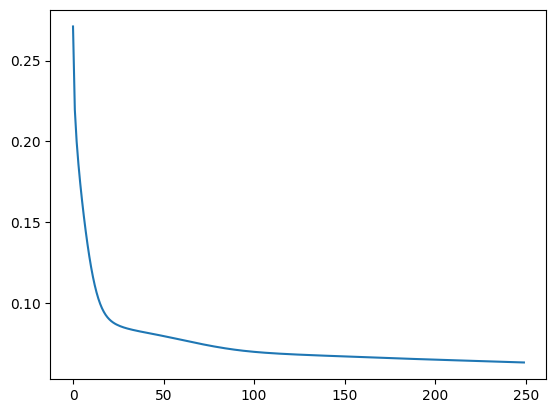

In [10]:
plt.plot(log_train)

In [ ]:
ver el espectro de fourier, errores en la derivada cada tantos epochs, 
cada tantas epochs calcular el gradiente sobre algunos puntps, lo mismo con el hessiano

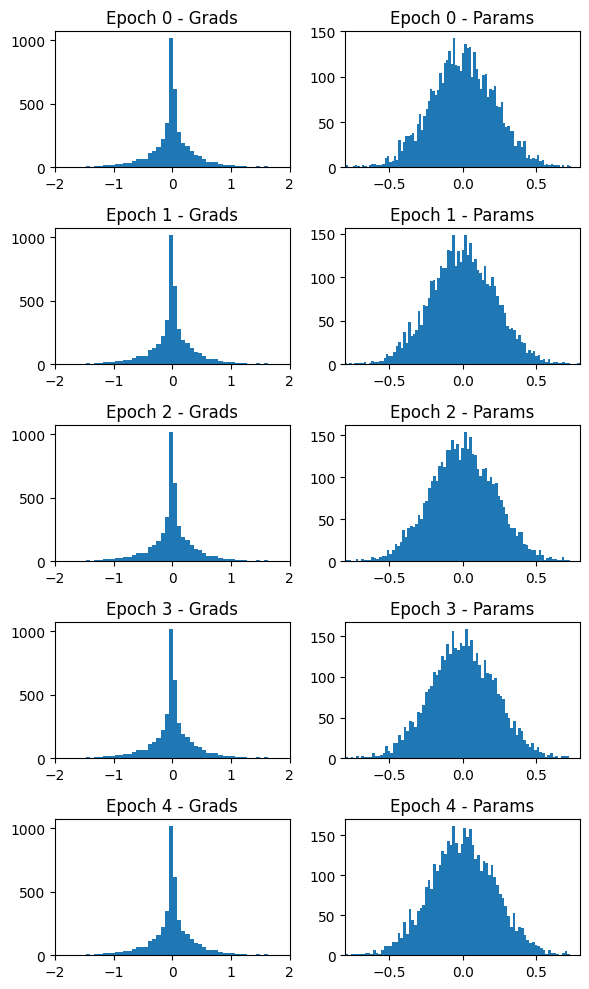

In [19]:
fig, axes = plt.subplots(num_epochs, 2, squeeze=False, figsize=(6, 2*num_epochs))  # num_epochs filas, 2 columnas

for i in range(num_epochs):
    axes[i, 0].hist(log_grads[i], bins=100)
    axes[i, 0].set_title(f"Epoch {i} - Grads")
    axes[i, 1].hist(log_params[i], bins=100)
    axes[i, 1].set_title(f"Epoch {i} - Params")

    axes[i, 0].set_xlim(-2, 2)
    axes[i, 1].set_xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()


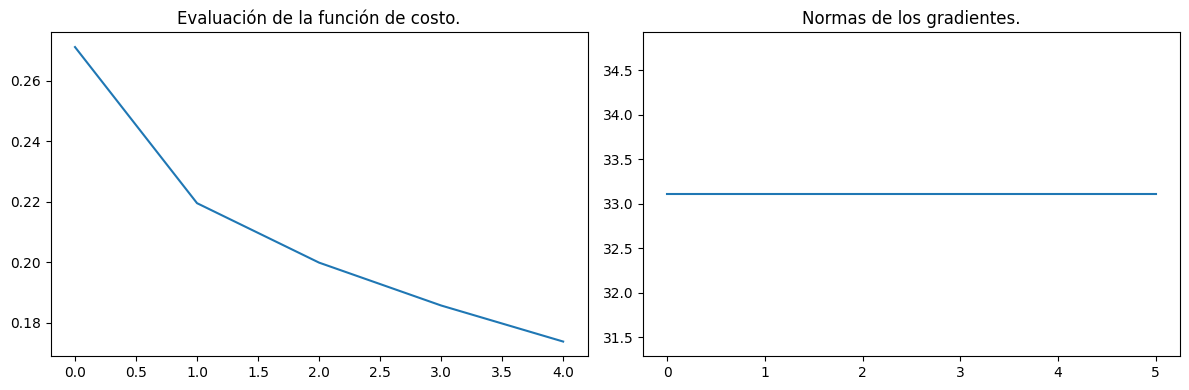

In [31]:
fig, axes = plt.subplots(1, 2, squeeze=False, figsize=(12, 4))

# Plot
axes[0, 0].plot(log_train)
axes[0, 0].set_title(f"Evaluación de la función de costo.")

axes[0, 1].plot(log_n_grads)
axes[0, 1].set_title(f"Normas de los gradientes.")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Simulación')

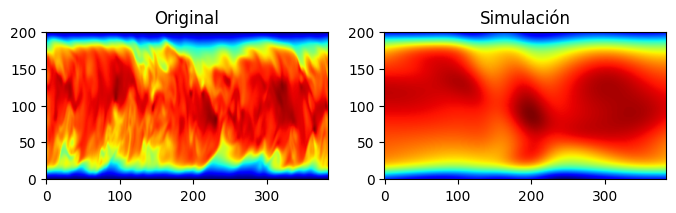

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[0].set_title(f"Original")
axes[1].imshow(batched_predict(params, xx).reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[1].set_title(f"Simulación")

In [ ]:



# Parameters
num_epochs = 1000
params = init_network_params(layer_sizes, random.key(0))
params = pack_params(params)
log_params = [params]

# optimizer
update = update_sgd
step_size = 0.001

# initialize gradients
xi, yi = next(get_batches(xx, ff, bs=32))
grads = grad(loss)(params, xi, yi)
aux = jnp.square(grads)
log_grads = [grads]

# Training
log_train = []
for epoch in range(num_epochs):
    # Update on each batch
    idxs = random.permutation(random.key(0), xx.shape[0])
    for xi, yi in get_batches(xx[idxs], ff[idxs], bs=32):
        params, aux = update(params, xi, yi, step_size, aux)

    log_params.append(params)
    log_grads.append(grads)

    train_loss = loss(params, xx, ff)
    log_train.append(train_loss)
    print(f"Epoch {epoch}, Loss: {train_loss}")

In [ ]:
lrs = [0.001, 0.01, 0.1]
mbs = [32, 64, 128]

listas = [lrs, mbs]
combinaciones = itertools.product(*listas)

for c in combinaciones: